In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

In [7]:
img = Image.open('pigs.jpg').convert('LA')
img = np.array(img)

In [8]:
size = (32,32)
cimg = img[:500,350:850][:,:,0]
crimg = Image.fromarray(cimg).resize(size)
crimg = np.array(crimg, dtype=float)/256
crimg.shape

(32, 32)

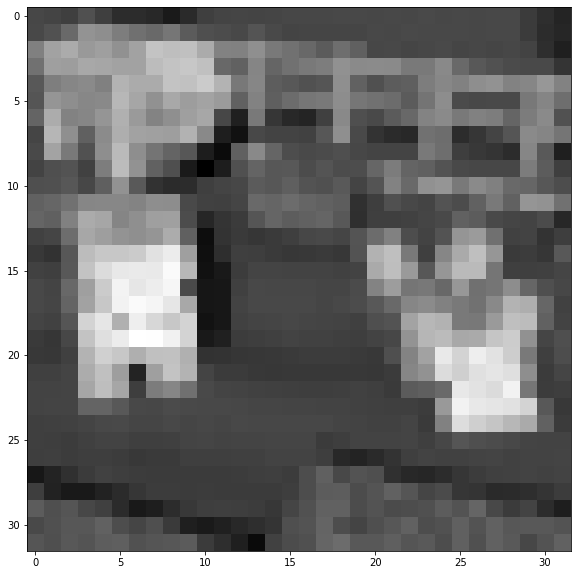

In [9]:
image = crimg
plt.figure(figsize=(10,10))
plt.imshow(image, 'gray')

# Theory
Image graph partitionong.
1. Find weights for all edges using (18) and build the
L matrix (7).
2. Choose the node of largest degree as the ground node, $v_g$,and determine $L_0$ and $d_0$ by eliminating the row/column corresponding to $v_g$.
3. Solve (13) for $x_0$.
4. Threshold the potentials x at the value that gives partitions
corresponding to the lowest isoperimetric ratio.
5. Continue recursion on each segment until the isoperimetric
ratio of the subpartitions is larger than the *stop* parameter.

**18:** $w_{ij} = exp(-\beta(I_i - I_j)^2)$  
**7:** $L_{v_i v_j} = \left\{
    \begin{array}{lr}
        d_i & if i == j\\
        -w(e_{ij}) & if e_{ij} \in E\\
        0 & otherwise
    \end{array}
\right.
$  

**13:** $L_0x_0 = d_0$

# Ideas for speedup
- Using hilbert curves for image unfoldong
- Using kernel method to compute W?

In [10]:
from modules import PIG 

## Step 1

In [11]:
graph = PIG(image)

PIG is done.


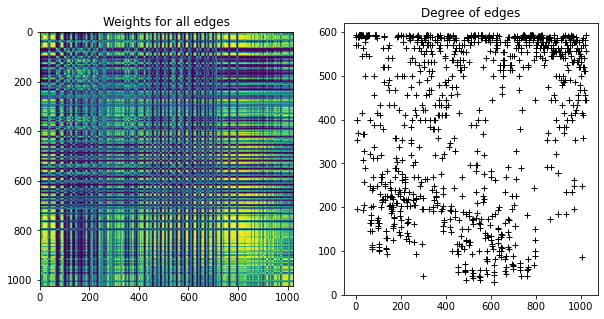

In [12]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].set_title('Weights for all edges')
ax[0].imshow(graph.weights)

ax[1].set_title('Degree of edges')
ax[1].plot(graph.degree, 'k+')
plt.show()

## Step 2
2. Choose the node of largest degree as the ground node, $v_g$,and determine $L_0$ and $d_0$ by eliminating the row/column corresponding to $v_g$.


In [13]:
print(f'Ground node: {graph.ground_node}')

Ground node: 0


In [14]:
graph.drop_ground_node()

## Step 3

In [15]:
# x = np.linalg.solve(L,D0)
x = graph.solve_self()

(1023,)


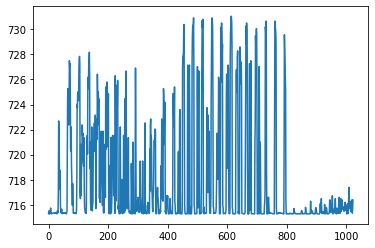

In [16]:
print(x.shape)
plt.plot(x)

## Step 4

In [17]:
th = graph._find_best_threshold()

Threshold: 716.0548304273269 | Isometric Ratio: 0.6328763143508384


In [ ]:
# FINISH THIS FUNCTION
1/0
graph.absorb_classes()


In [19]:
N = len(graph)
x = graph.x
ground_node = graph.ground_node

In [20]:
new_x = np.zeros(N)
new_x[:ground_node] = x[:ground_node]
new_x[ground_node+1:] = x[ground_node:]
new_x.shape

(1024,)

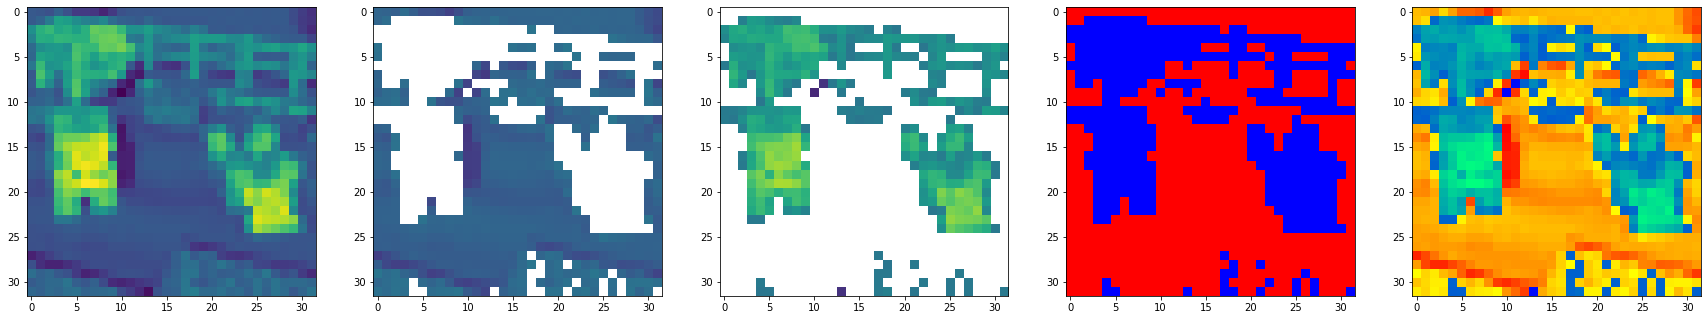

In [24]:
threshold =  graph.threshold
# threshold = lower_th

rnew_x = new_x.reshape(size)

fig,ax = plt.subplots(1,5,figsize=(30,15))

ax[0].imshow(crimg)
ax[1].imshow(np.ma.masked_where(rnew_x > threshold, crimg), vmin=0, vmax=1)
ax[2].imshow(np.ma.masked_where(rnew_x <= threshold, crimg), vmin=0, vmax=1)

ax[3].imshow(np.ma.masked_where(rnew_x > threshold, rnew_x >= threshold), 'autumn')
ax[3].imshow(np.ma.masked_where(rnew_x <= threshold, rnew_x < threshold), 'winter')

ax[4].imshow(np.ma.masked_where(rnew_x > threshold, crimg), 'autumn')
ax[4].imshow(np.ma.masked_where(rnew_x <= threshold, crimg), 'winter')
fig.show()

In [33]:
# What next?
set_a_cond = graph.x < graph.threshold


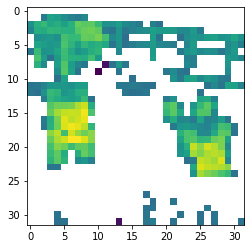

In [30]:
plt.imshow(np.ma.masked_where(rnew_x <= threshold, crimg))

In [41]:
D = graph.degree
L = graph.laplace

In [43]:
gn = graph.ground_node

In [49]:
D[gn] = 0
L[:,gn] = 0
L[gn] = 0

In [52]:
np.linalg.solve(L,D)

LinAlgError: Singular matrix

In [23]:
# New W
# Preparing for next recursive loop
next_set_idxs = np.where(new_x < threshold)[0]
print(next_set_idxs.shape)

W = W[next_set_idxs][:,next_set_idxs]
W.shape

# and go back to the beggining

(626,)


(626, 626)

In [55]:
set_idxs = np.concatenate((next_set_idxs[:ground_node], next_set_idxs[ground_node+1:]))

new_x = np.zeros(32*32) -1
new_x[set_idxs] = x



In [51]:
new_x[set_idxs] = 1

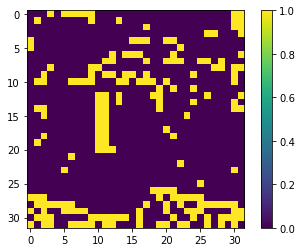

In [60]:
plt.imshow(new_x.reshape((32,32)) > threshold)
plt.colorbar()